In [1]:
%load_ext autoreload
%autoreload
import sys, os
import numpy as np
import scipy.optimize as optimize
import scipy.fftpack as fft
import scipy.integrate as integrate
import scipy.linalg as linalg
from scipy.stats import linregress
import scipy.signal as signal

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from chi2 import *

mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 15

/home/jean/miniconda3/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jean/miniconda3/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def curve_fit( func, x, y, sigma, p0 ):
    fit = optimize.leastsq( lambda args: (func(x, *args)-y)/sigma, x0=p0, full_output=1, ftol=1e-8, gtol=1e-8, xtol=1e-8 )
    cov = fit[1]
    fit = fit[0]
    fitval = func(x, *fit)
    s_sq = np.sum( ((fitval-y)/sigma)**2 )/(len(x) - 2)
    if(len(x)==2):
        s_sq = np.sum( ((fitval-y)/sigma)**2 )/len(x)
    if cov is not None:
        cov = cov * s_sq
        fiterr = np.sqrt(np.diag(cov))
    else:
        print("NONE")
        fiterr = np.ones(len(fit))*1e9
    return fit, fiterr

def least_sq( y, yfit ):
    return sum( (y - yfit)**2 )

In [4]:
n = 200
dt = 1e-3
times_tot = np.arange( 1e4 )*dt
times = np.arange(1e4-2*n)*dt
times = times - max(times)
nyq = 1/dt/2

In [56]:
filtup_arr = np.logspace(np.log10(1.5), np.log10(nyq-1), 200)
erravefilt_arr = []
errave_arr = []
phasediff_arr = []
phase_arr_tot = []
phasefilt_arr_tot = []
truephase_arr = []
d = signal.firwin(101, [0.5, 300], nyq=nyq, window='hamming', pass_zero=False)
res_arr = []
resfilt_arr = []
phase_arr = []
phasefilt_arr = []
norm_arr = []
normfilt_arr = []
errphase_arr = []
errphasefilt_arr = []
errnorm_arr = []
errnormfilt_arr = []
phase = 2*np.pi*np.random.rand()
sigma = 1e-5
for i in range(100):
    sig_tot = np.sin(2*np.pi*1*times_tot+phase) + np.random.normal(0,sigma,size=len(times_tot))
    sig = sig_tot[n:-n].copy()
    filtered_sig = signal.convolve(sig_tot, d, mode='same', method='auto')[n:-n]

    paraOut = optimize.minimize( lambda para: least_sq(sig, para[0]*np.sin(2*np.pi*times) + para[1]*np.cos(2*np.pi*times)), [ 0.1, 0.1 ], method="SLSQP", tol=1e-10, options={'eps': 1e-12, 'ftol':1e-10, 'maxiter':5000} ).x
    paraOut, errtout = curve_fit( lambda t, *para: para[0]*np.sin(2*np.pi*t) + para[1]*np.cos(2*np.pi*t), times, sig, np.ones(len(times)), paraOut)

    paraOut_filt = optimize.minimize( lambda para: least_sq(filtered_sig, para[0]*np.sin(2*np.pi*times) + para[1]*np.cos(2*np.pi*times)), [ 0.1, 0.1 ], method="SLSQP", tol=1e-30, options={'eps': 1e-12, 'ftol':1e-10, 'maxiter':5000} ).x
    paraOut_filt, errtout_filt = curve_fit( lambda t, *para: para[0]*np.sin(2*np.pi*t) + para[1]*np.cos(2*np.pi*t), times, filtered_sig, np.ones(len(times)), paraOut_filt)

    norm_arr.append(np.sqrt(paraOut[1]**2 + paraOut[0]**2))
    normfilt_arr.append(np.sqrt(paraOut_filt[1]**2 + paraOut_filt[0]**2))

    phase_arr.append(np.arctan2(paraOut[1], paraOut[0]))
    phasefilt_arr.append(np.arctan2(paraOut_filt[1], paraOut_filt[0]))

    errphase_arr.append(np.abs(paraOut[0]*paraOut[1])/norm_arr[-1]**(-2) * np.sqrt( (errtout[0]/paraOut[0])**2 + (errtout[1]/paraOut[1])**2 ))
    errphasefilt_arr.append(np.abs(paraOut_filt[0]*paraOut_filt[1])/(paraOut_filt[0]**2+paraOut_filt[1]**2) * np.sqrt( (errtout_filt[0]/paraOut_filt[0])**2 + (errtout_filt[1]/paraOut_filt[1])**2 ))

    errnorm_arr.append(norm_arr[-1]**(-1) * np.sqrt( (errtout[0]*paraOut[0])**2 + (errtout[1]*paraOut[1])**2 ))
    errnormfilt_arr.append(normfilt_arr[-1]**(-1) * np.sqrt( (errtout_filt[0]*paraOut_filt[0])**2 + (errtout_filt[1]*paraOut_filt[1])**2 ))

    res_arr.append(np.sum((paraOut[0]*np.sin(2*np.pi*times) + paraOut[1]*np.cos(2*np.pi*times) - sig)**2))
    resfilt_arr.append(np.sum((paraOut_filt[0]*np.sin(2*np.pi*times) + paraOut_filt[1]*np.cos(2*np.pi*times) - filtered_sig)**2))
res_arr = np.array(res_arr)
resfilt_arr = np.array(resfilt_arr)
phase_arr = np.array(phase_arr)
phasefilt_arr = np.array(phasefilt_arr)
norm_arr = np.array(norm_arr)
normfilt_arr = np.array(normfilt_arr)
errphase_arr = np.array(errphase_arr)
errphasefilt_arr = np.array(errphasefilt_arr)
errnorm_arr = np.array(errnorm_arr)
errnormfilt_arr = np.array(errnormfilt_arr)

Standard Deviation: 2.1566082253343666e-14
Cramer Rao: 2.0833333333333337e-14
2.0749789106962224e-14


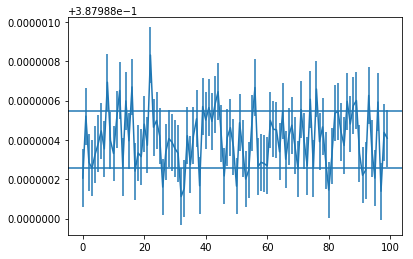

In [66]:
plt.errorbar(range(len(phase_arr)), phase_arr, errphase_arr)
SNR = 1**2/(2*(sigma)**2)
CRLB = 1/(len(sig)*SNR)
plt.axhline(np.mean(phase_arr)+np.sqrt(CRLB))
plt.axhline(np.mean(phase_arr)-np.sqrt(CRLB))
print('Standard Deviation:', np.sum(phase_arr**2)/len(phase_arr) - (np.sum(phase_arr)/len(phase_arr))**2)
print('Cramer Rao:', CRLB)

In [36]:
filtup_arr = np.logspace(np.log10(1.2), np.log10(nyq-1), 10)
erravefilt_arr = []
errave_arr = []
phasediff_arr = []
phase_arr_tot = []
phasefilt_arr_tot = []
truephase_arr = []
for filt in filtup_arr:
    d = signal.firwin(101, [0.8, filt], nyq=nyq, window='hamming', pass_zero=False)
    phase = 2*np.pi*np.random.rand()
    for i in range(1):
        sig_tot = np.random.normal(0,1e-5,size=len(times_tot))
        sig = sig_tot[n:-n].copy()
        
        paraOut = optimize.minimize( lambda para: least_sq(sig, para[0]*np.sin(2*np.pi*times) + para[1]*np.cos(2*np.pi*times)), [ 0.1, 0.1 ], method="SLSQP", tol=1e-30, options={'eps': 1e-12, 'ftol':1e-30, 'maxiter':5000} ).x
        paraOut, errtout = curve_fit( lambda t, *para: para[0]*np.sin(2*np.pi*t) + para[1]*np.cos(2*np.pi*t), times, sig, np.ones(len(times)), paraOut)

        paraOut_filt = optimize.minimize( lambda para: least_sq(filtered_sig, para[0]*np.sin(2*np.pi*times) + para[1]*np.cos(2*np.pi*times)), [ 0.1, 0.1 ], method="SLSQP", tol=1e-30, options={'eps': 1e-12, 'ftol':1e-30, 'maxiter':5000} ).x
        paraOut_filt, errtout_filt = curve_fit( lambda t, *para: para[0]*np.sin(2*np.pi*t) + para[1]*np.cos(2*np.pi*t), times, filtered_sig, np.ones(len(times)), paraOut_filt)
        print(np.sqrt(paraOut_filt[0]**2+paraOut_filt[1]**2))
#         plt.plot(times, sig-(paraOut[0]*np.sin(2*np.pi*times) + paraOut[1]*np.cos(2*np.pi*times)))
#         plt.plot(times, filtered_sig-(paraOut_filt[0]*np.sin(2*np.pi*times) + paraOut_filt[1]*np.cos(2*np.pi*times)))
#         plt.show()

9.714596233516033e-08
9.714596233516033e-08
9.714596233516033e-08
9.714596233516033e-08
9.714596233516033e-08
9.714596233516033e-08
9.714596233516033e-08
9.714596233516033e-08
9.714596233516033e-08
9.714596233516033e-08
